In [11]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed
import random

In [12]:
mp.Verbosity(2)

resolution = 20

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

pml_thickness = 0.780
height_pillar = 1.020
width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a * 3
cell_y = a * 3
cell_z = round(2*pml_thickness + width_PDMS + height_pillar +  width_fusedSilica, 3)

center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
                    + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
z_PDMS = height_pillar + width_PDMS + pml_thickness

In [13]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica)),
            mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    center=mp.Vector3(0,0,center_PDMS),
                    material=mp.Medium(index=n_PDMS))]

k_point = mp.Vector3(0,0,0)
#k_point = mp.Vector3(np.radians(35), 0, 0)  # k vector defines normal to the plane of propagation

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 15 # this is the number of pillars we will build
data = np.zeros((3,num))
dfts = []

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

fcen = freq
fwidth=0.2*freq

sources = [mp.Source(mp.GaussianSource(fcen, fwidth=fwidth), component = source_cmpt,
                            center=mp.Vector3(0,0,center_source),
                            size=mp.Vector3(cell_x,cell_y,0))]

def run_sim():
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, source_cmpt, mp.Vector3(0, 0, cell_z), 1e-2))

In [14]:
cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    #symmetries=symmetries,
                    resolution=resolution)
nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.3*width_PDMS, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

# fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
#             size=mp.Vector3(a, a, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)
where=mp.Volume(center=mp.Vector3(0, 0, fr_center), size=mp.Vector3(cell_x, cell_y, 0))
dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)
run_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000120878 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.683761 s
-----------
on time step 1576 (time=39.4), 0.00253909 s/step
field decay(t = 50.025000000000006): 0.12053885221037682 / 0.12053885221037682 = 1.0
on time step 3263 (time=81.575), 0.00237244 s/step
field decay(t = 100.05000000000001): 0.028505959764893892 / 0.12053885221037682 = 0.23648773189861105
on time step 4951 (time=123.775), 0.00237076 s/step
field decay(t = 150.07500000000002): 6.901501745057479e-09 / 0.12053885221037682 = 5.72554128

In [15]:
initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux
initial_dft = [sim.get_dft_array(dft_object, mp.Ex, 0),
               sim.get_dft_array(dft_object, mp.Ey, 0),
               sim.get_dft_array(dft_object, mp.Ez, 0)]
sim.reset_meep()
print(initial_flux)

10.5126710512241


In [16]:
x_list = [-a, 0, a, -a, 0, a, -a, 0, a]
y_list = [a, a, a, 0, 0, 0, -a, -a, -a] 
radii_list = np.random.uniform(0.075, 0.250, 9)

for i, neighbor in enumerate(radii_list):
    radius = neighbor
    x_dim = x_list[i]
    y_dim = y_list[i]
    geometry.append(mp.Cylinder(radius=radii_list[i],
                                height=height_pillar,
                                axis=mp.Vector3(0,0,1),
                                center=mp.Vector3(x_list[i], y_list[i], center_pillar),
                                material=mp.Medium(index=n_amorphousSi)))

In [17]:
pbar = tqdm(total=num,leave=False)
central_index = None
for i,radius in enumerate(np.linspace(0.075,0.25,num=num)):
    for j, pillar in enumerate(geometry):
        if pillar.center == mp.Vector3(0,0,center_pillar):
            central_index = j
            print(f"central_index = {j}")
    if central_index is not None:
        geometry.pop(central_index)
    print(f"central pillar: {radius}")
    geometry.append(mp.Cylinder(radius=radius,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi)))

    print(f"at iteration {i} the central pillar is at {geometry[central_index].center} with {geometry[central_index].radius}")
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        #symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  
    dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)
    
    run_sim()
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    # if(radius!=0.25):
    #     sim.reset_meep()
    #     print(f"i= {i},radius={radius}")
    #     geometry.pop(5)
    dfts.append([sim.get_dft_array(dft_object, mp.Ex, 0), sim.get_dft_array(dft_object, mp.Ey, 0), sim.get_dft_array(dft_object, mp.Ez, 0)])

    pbar.update(1)
pbar.close()

  0%|                                                                             | 0/15 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 6
central pillar: 0.075
at iteration 0 the central pillar is at Vector3<0.68, 0.0, -0.39> with 0.11656847674731535
-----------
Initializing structure...
time for choose_chunkdivision = 8.29697e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     

field decay(t = 150.07500000000002): 2.7972212784783946e-05 / 0.011576461570685394 = 0.0024163007507939085
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


  7%|████▌                                                                | 1/15 [00:16<03:52, 16.59s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.0875
at iteration 1 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.0875
-----------
Initializing structure...
time for choose_chunkdivision = 4.60148e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, ce

field decay(t = 150.07500000000002): 2.926059174523128e-05 / 0.01900972093948374 = 0.0015392436237428495
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 13%|█████████▏                                                           | 2/15 [00:32<03:33, 16.44s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.09999999999999999
at iteration 2 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.09999999999999999
-----------
Initializing structure...
time for choose_chunkdivision = 4.79221e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,

field decay(t = 150.07500000000002): 4.549782724952294e-05 / 0.038421006537680435 = 0.0011841914449821113
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 20%|█████████████▊                                                       | 3/15 [00:49<03:17, 16.44s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.11249999999999999
at iteration 3 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.11249999999999999
-----------
Initializing structure...
time for choose_chunkdivision = 4.50611e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,

field decay(t = 150.07500000000002): 8.14617363642633e-05 / 0.0654475077329288 = 0.0012446881353631318
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 27%|██████████████████▍                                                  | 4/15 [01:05<03:00, 16.38s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.125
at iteration 4 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.125
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, cent

field decay(t = 150.07500000000002): 0.00016830296793880523 / 0.12629047158758958 = 0.0013326656067008
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 33%|███████████████████████                                              | 5/15 [01:21<02:43, 16.35s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.13749999999999998
at iteration 5 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.13749999999999998
-----------
Initializing structure...
time for choose_chunkdivision = 4.3869e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,1

field decay(t = 150.07500000000002): 8.413319387624221e-05 / 0.2526617147153865 = 0.0003329875045414575
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 40%|███████████████████████████▌                                         | 6/15 [01:38<02:26, 16.33s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.15
at iteration 6 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.15
-----------
Initializing structure...
time for choose_chunkdivision = 4.3869e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center 

field decay(t = 150.07500000000002): 0.0004121121720317225 / 0.41024226455728596 = 0.0010045580566313771
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 47%|████████████████████████████████▏                                    | 7/15 [01:54<02:10, 16.36s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.16249999999999998
at iteration 7 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.16249999999999998
-----------
Initializing structure...
time for choose_chunkdivision = 4.1008e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,1

field decay(t = 150.07500000000002): 0.0011457353259288153 / 0.47975975302893176 = 0.0023881438963883287
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 53%|████████████████████████████████████▊                                | 8/15 [02:10<01:54, 16.31s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.175
at iteration 8 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.175
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, cent

field decay(t = 150.07500000000002): 0.0003804436982661106 / 0.4694806581647032 = 0.0008103500999452109
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 60%|█████████████████████████████████████████▍                           | 9/15 [02:27<01:37, 16.31s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.1875
at iteration 9 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.1875
-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, ce

field decay(t = 150.07500000000002): 0.00036095320550245794 / 0.37761056405431 = 0.0009558874667779255
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 67%|█████████████████████████████████████████████▎                      | 10/15 [02:43<01:21, 16.37s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.19999999999999998
at iteration 10 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.19999999999999998
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,

field decay(t = 150.07500000000002): 0.0011029715666945647 / 0.2717165982379387 = 0.004059271954114142
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 73%|█████████████████████████████████████████████████▊                  | 11/15 [03:00<01:05, 16.38s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.21249999999999997
at iteration 11 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.21249999999999997
-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104

field decay(t = 150.07500000000002): 0.0007820397833472778 / 0.21091995060555987 = 0.0037077563364774613
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 80%|██████████████████████████████████████████████████████▍             | 12/15 [03:16<00:49, 16.49s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.22499999999999998
at iteration 12 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.22499999999999998
-----------
Initializing structure...
time for choose_chunkdivision = 4.31538e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104

field decay(t = 150.07500000000002): 0.0009418274832716622 / 0.17852225389332083 = 0.005275686715419065
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 87%|██████████████████████████████████████████████████████████▉         | 13/15 [03:33<00:32, 16.49s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.2375
at iteration 13 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.2375
-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, c

field decay(t = 200.10000000000002): 0.00016136777791661658 / 0.16923500620664186 = 0.0009535129967116903
run 0 finished at t = 200.10000000000002 (8004 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 93%|███████████████████████████████████████████████████████████████▍    | 14/15 [03:55<00:18, 18.09s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.25
at iteration 14 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.25
-----------
Initializing structure...
time for choose_chunkdivision = 4.31538e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.201033, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.215939, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, cente

field decay(t = 200.10000000000002): 0.00014244099122924208 / 0.1445308398375637 = 0.0009855404658917753
run 0 finished at t = 200.10000000000002 (8004 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


In [18]:
def get_intensity(Ex, Ey, Ez):
    E_0 = np.sqrt((abs(Ex)**2 + abs(Ey)**2 + abs(Ez)**2))
    I = 0.5 * E_0**2
    return(np.mean(I))

initial_I = get_intensity(initial_dft[0], initial_dft[1], initial_dft[2])
I_list = []

for dft in dfts:
    I = get_intensity(dft[0], dft[1], dft[2])
    I_list.append(I / initial_I)

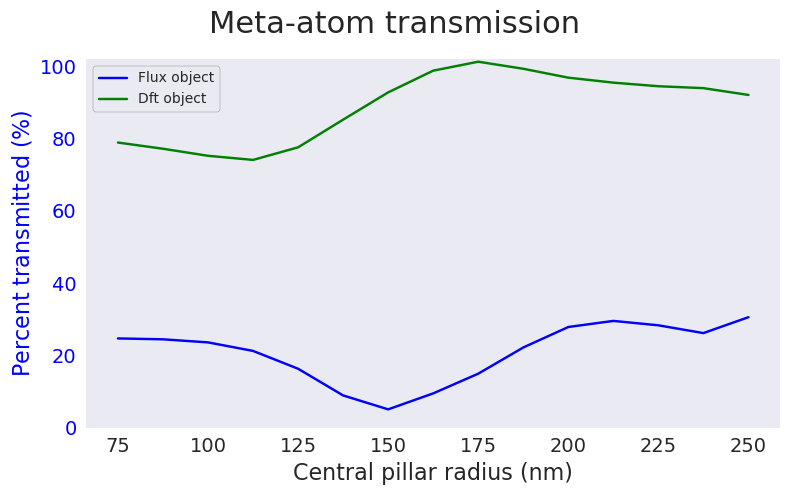

In [29]:
radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

#plt.style.use('seaborn')

results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phase and transmission
plt.style.use('seaborn-v0_8')

tickfontsize=14
labelfontsize=16
titlefontsize=22
padding = 0.02
plt.close("all")
fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom transmission",fontsize=titlefontsize)

ax.set_xlabel("Central pillar radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1+padding])
ax.set_ylabel(r'Percent transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Flux object')
ax.plot(radii,I_list,'green',label='Dft object')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

ax.legend(frameon=True, edgecolor='dimgrey')
# twin1 = ax.twinx()

# twin1.set_ylim([-np.pi,np.pi])
# twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
# twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
# twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
# twin1.plot(radii,phase_list,'r',label='Phase')
# twin1.tick_params(axis='y', labelcolor = 'red')

plt.grid(False)
plt.tight_layout()

In [ ]:
plt.close("all")
plt.figure(figsize=(8,8))
plot_plane = mp.Volume(center=mp.Vector3(0,0,fr_center),
                            size=mp.Vector3(cell_x,cell_y,0))
sim.plot2D(output_plane=plot_plane,
           #fields=mp.Ey
           )
plt.grid(False)

In [31]:
sim.reset_meep()

## it would be interesting to see these characteristics for different random neighbors, as well as uniform neighbors